## El objetivo de este ejercicio es calcular la función de política óptima epsilon greedy ("epsilon-ávida")
<img src="Epsilon_Greedy_MC.PNG">

In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
# vamos a utilizar el ambiente de BlackJack como ejemplo
env = BlackjackEnv()

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Crea una política epsilon-greedy basado en una q-función (función de valor estado-acción) y un epsilon dados.
    
    Argumentos:
        Q: un diccionario que mapea cada estado/observación s a un array de numpy Q[s] = array([v_0, v_1, ... , v_nA]) de longitud nA
        que para un índice a del array contiene el valor v_a de tomar la acción a en el estado s. 
        (en nuestra notación de la clase q(s,a))
         
        epsilon: probabilidad de seleccionar una acción aleatoria (obliga a explorar), valor entre 0 y 1.
        
        nA: número de acciones en el entorno
    
    Retorna:
        Una función que dada una observación como argumento, retorna una política (un array de numpy de longitud nA)
        con probabilidades para cada acción. La política es tal que toma la mejor acción según Q con probabilidad (1-epsilon)
        y toma una acción al azar con probabilidad epsilon
        
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [4]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Control Monte Carlo utiliando políticas epsilon-greedy
    Encuentra la política epsilon-greedy óptima.
    
    Argumentos:
        env: ambiente de OpenAI gym.
        num_episodes: número de episodios a samplear.
        discount_factor: factor de descuento gama.
        epsilon: probabilidad de samplear una acción aleatoria. Valor entre 0 y 1.
    
    Retorna:
        Una tupla (Q, policy)
        Q es un diccionario que mapea cada estado/observación s a un array de numpy Q[s] = array([v_0, v_1, ... , v_nA]) de longitud nA
        que para un índice a del array contiene el valor v_a de tomar la acción a en el estado s. 
        (en nuestra notación de la clase q(s,a))
        policy es una función que toma una observación/estado como argumento y retorna un array numpy 
        de longitud nA con las probabilidades de cada acción
        
    """
    
    # mantienen la suma y la cantidad de retornos para cada estado
    # para calcular un promedio. Podríamos utilizar un array para guardar todos los retornos
    # también, pero sería más infeciente en términos de espacio
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # La función de valor estado-acción resultante
    # un diccionario que para cada estado devuelve un array de numpy de longitud nA
    # con las probabilidades de cada acción
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    # la política que estamos siguiendo
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
   
    # por cada episodio de num_episodes en total
    for i_episode in range(1, num_episodes + 1):
        # printear el número de episodio
        if i_episode % 1000 == 0:
            print("\rEpisodio {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # paso 1: generar un episodio
        # para ello:
        # resetear el ambiente y obtener el primer estado
        episode = []
        state = env.reset()
        # por cada t de 0 a 99 (limitamos la longitud de los episodios a 100)
        for t in range(100):
            # obtener las probabilidades de la política dado el estado en que estamos
            probs = policy(state)
            # hallar la próxima acción según la distribución de la política
            action = np.random.choice(np.arange(len(probs)), p=probs)
            # agregar la tupla (estado, acción, recompensa) al episodio
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            # si el episodio acabó: pasar al próximo episodio
            if done:
                break
            # actualizar el estado en el que estamos para realizar la transición
            state = next_state
        
            
        # paso 2: actualizar la función Q con la información del episodio
        # para ello, 
        # por cada tupla (estado, acción) en el episodio
        # (TIP: ES POSIBLE USAR set() para obtener las tuplas únicas (estado, acción)
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            # obtener la primera vez que ocurre la tupla
            first_occurence_idx = next(i for i,x in enumerate(episode)
                                       if x[0] == state and x[1] == action)
            # sumar todas las recompensas a partir de ese punto descontadas por gama
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # para obtener G, el retorno el episodio
            # en el diccionario returns_sum acumular para la tupla (estado, acción) el retorno obtenido
            # en el diccionario returns_count adicionar una visita a la tupla (estado, acción)
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            # actualizar Q[estado][accion] dado los nuevos valores de returns_sum y returns_count
            # podemos utilizar la fórmula de la media usual:
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
            # o usar la fórmula para la media incremental:
            #Q[state][action] = Q[state][action] + 1/returns_count[state] * (G - Q[state][action])
        
        # NOTAR: el diccionario de Q se actualiza en cada episodio, y por lo tanto también se 
        # actualiza la función policy, que utiliza ese diccionario, mirar la última celda de este
        # notebook para entender por qué
    
    
    return Q, policy

In [5]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

Episodio 500000/500000.

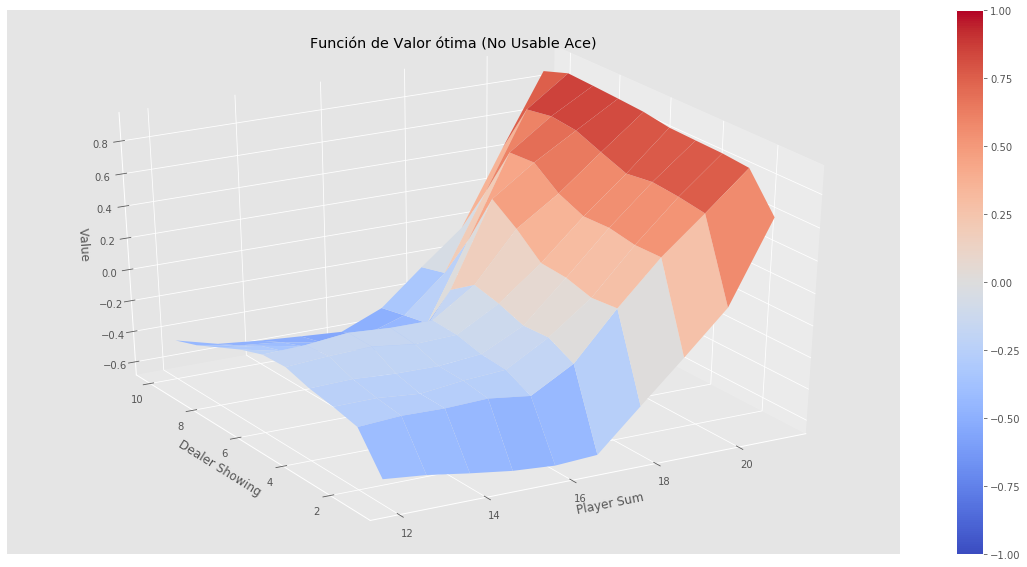

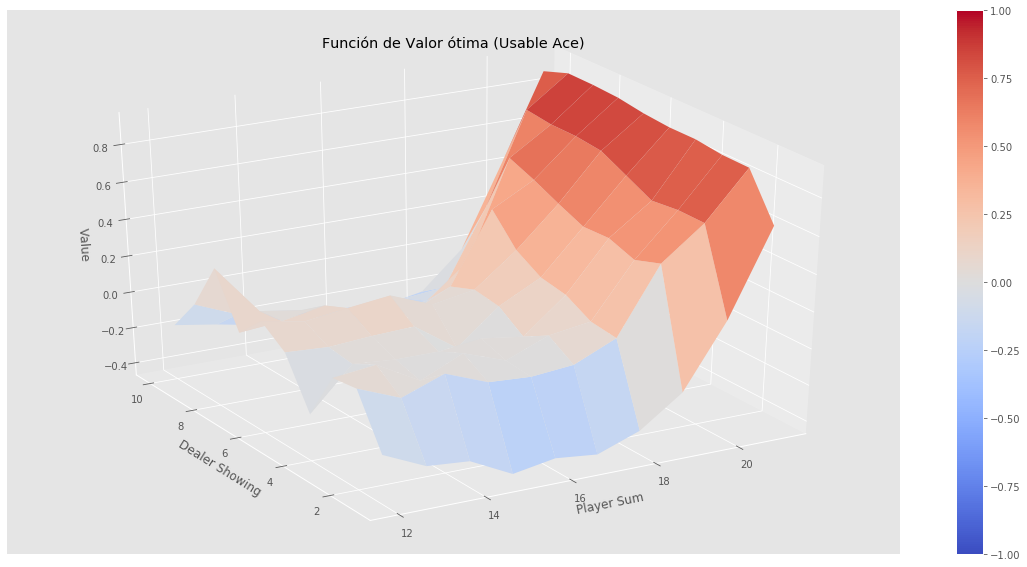

In [6]:
# Para plotear: crear una función valor dada una función valor de estado-acción
# eligiendo la mejor acción en cada estado
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Función de Valor ótima")

In [9]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
def plot_best_action(V, policy, title="Mejor accion"):
    """
    Plotea la mejor accion en blackjack segun Q
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)
    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: np.argmax(policy((_[0], _[1], False))), 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: np.argmax(policy((_[0], _[1], True))), 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))

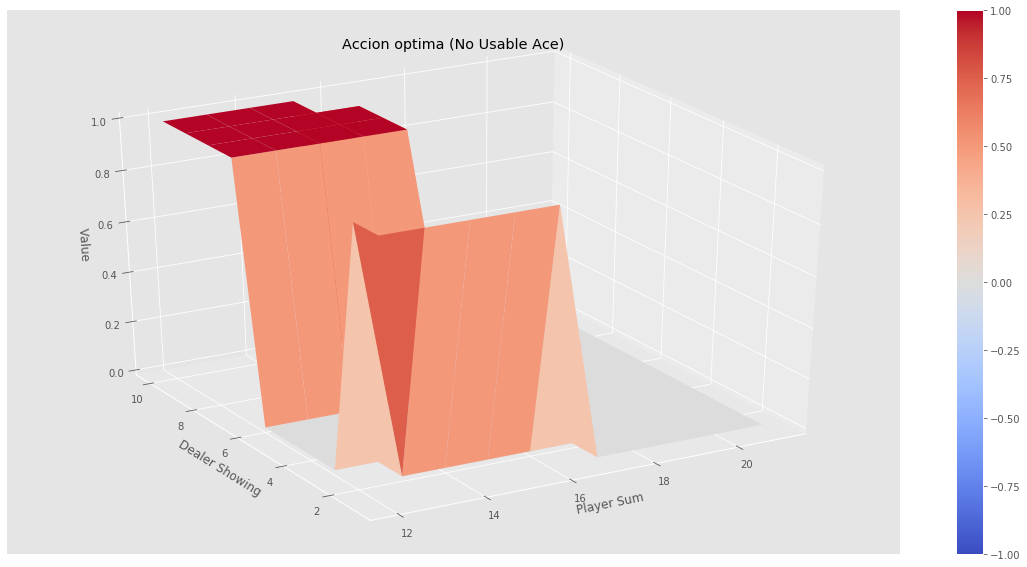

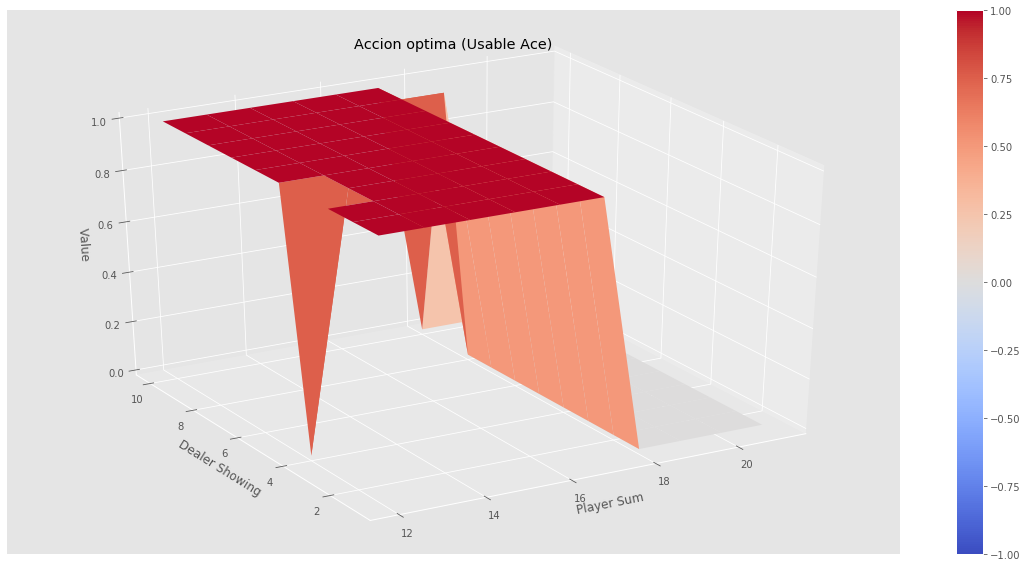

In [10]:
plot_best_action(V, policy, title="Accion optima")

In [9]:
# ejemplo de cómo la política se actualiza cuando Q se actualiza
import numpy as np
from collections import defaultdict
tt = defaultdict(lambda: np.zeros(10))
def func_get_back_tt(tt):
    def tt_back(a):
        return tt[a]
    return tt_back
tt_back = func_get_back_tt(tt)
tt[0] += np.ones(10)
print(tt_back(0))
tt[0] += np.ones(10)
print(tt_back(0))


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
